In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import OrderedDict

from scipy.io import wavfile

from sklearn import metrics

import shutil
import os
import zipfile
import tarfile

import time
import random
#import torchaudio

import wave

import torch
from torch import nn

import pickle

from torchsummary import summary

import IPython.display as ipd

%matplotlib inline

In [2]:
dataset_type = input('Pick a dataset from the following\nby writing a letter in the upper case\nI (IEMOCAP), R (RAVDESS), C (CREMA-D):')

dataset_type = dataset_type.upper()

dataset_type_dict = {
    'Name': ['CREMA-D', 'IEMOCAP', 'RAVDESS'],
    'Archive name': ['crema_d-audio_np-sr_22050.tar.xz', 'iemocap_numpy_audio_sr22050.tar.xz', 'ravdess-speech-sr22050.tar.xz']}
datasets_info = pd.DataFrame(dataset_type_dict, index=['C', 'I', 'R'])
 

print('You have picked {} dataset'.format(datasets_info['Name'][dataset_type]))

You have picked CREMA-D dataset


In [35]:
def get_paths_to_wavs(path_to_dataset):
    file_paths_list = []

    for root, dirs, files in os.walk(path_to_dataset):
        if len(files) != 0:
            file_paths_list += [os.path.join(root, f) for f in files if f.endswith('.wav')]

    return file_paths_list

def get_paths_to_npys(path_to_dataset):
    # get a list with all absolute paths to each file
    file_paths_list = []

    for root, dirs, files in os.walk(path_to_dataset):
        if len(files) != 0:
            file_paths_list += [os.path.join(root, f) for f in files if f.endswith('.npy')]
            #file_paths_list += [os.path.join(root, f) for f in files if os.path.isdir(os.path.join(root, f))]

    return file_paths_list

class numpy_ravdess_dataset(torch.utils.data.Dataset):
    '''
    Due to librosa reads wav-files very slow it is more preferable to read the
    numpy representations of the original wavs
    '''

    emotions_dict = {
        0: 'neutral',
        1: 'calm',
        2: 'happy',
        3: 'sad',
        4: 'angry',
        5: 'fearful',
        6: 'disgust',
        7: 'surprised'
        }

    def __init__(self, paths_to_wavs_list, spectrogram_shape, mode):
        super(numpy_ravdess_dataset, self).__init__()

        self.paths_to_wavs_list = paths_to_wavs_list

        self.mfcc_rows = spectrogram_shape[0]
        self.mfcc_cols = spectrogram_shape[1]
        self.mode = mode

    def __len__(self):
        return len(self.paths_to_wavs_list)
    '''
    def read_audio(self, path_to_wav):
        return np.load(path_to_wav, allow_pickle=True)
    '''
    def read_audio(self, path_to_wav):
        sr, wav = wavfile.read(path_to_wav)
        wav = (wav / 32768).astype(np.float32)
        return wav, sr

    def get_class_label(self, path_to_file):
        # Parse the filename, which has the following pattern:
        # modality-vocal_channel-emotion-intensity-statement-repetition-actor.wav
        # e.g., '02-01-06-01-02-01-12.wav'
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        class_label = int(file_name.split('-')[2]) - 1 # 2 is a number of emotion code
        return class_label
        

    def __getitem__(self, idx):
        path_to_wav = self.paths_to_wavs_list[idx]
        # debug
        #print(path_to_wav)

        # read the wav file
        wav, sr = self.read_audio(path_to_wav)
        #wav, sr = librosa.load(path_to_wav)

        # augment by noise
        '''
        if self.mode == 'TRAIN':
            if random.randint(0,2) == 1:
                sigma = np.random.uniform(0.5, 1.52)
                noise = sigma * np.random.randn(len(wav))
                wav += noise
        '''
        # get mfcc coefficients
        #mfccs = librosa.feature.mfcc(wav, sr=sr, n_mfcc=self.mfcc_rows, n_mels=self.mfcc_rows).astype(np.float32)
        #mfccs = librosa.feature.melspectrogram(wav, sr=sr, n_mels=self.mfcc_rows).astype(np.float32)
        mfccs = librosa.core.stft(wav, n_fft=512)#.astype(np.float32)
        mfccs = np.abs(mfccs)#**2
        mfccs = np.log(mfccs + 0.01)

        #mfccs = (mfccs - mfccs.mean())/np.std(mfccs)

        actual_mfcc_cols = mfccs.shape[1]

        # prmitive time-shifting augmentation
        target_real_diff = actual_mfcc_cols - self.mfcc_cols
        if target_real_diff > 0:
            
            if self.mode == 'TRAIN':
                beginning_col = np.random.randint(target_real_diff)
            else:
                
                beginning_col = actual_mfcc_cols//2 - self.mfcc_cols//2
            mfccs = mfccs[:-1, beginning_col:beginning_col + self.mfcc_cols]

        elif target_real_diff < 0:
            zeros = np.zeros((self.mfcc_rows, self.mfcc_cols), dtype=np.float32)
            
            if self.mode == 'TRAIN':
                beginning_col = np.random.randint(self.mfcc_cols-actual_mfcc_cols)
            else:
            
                beginning_col = self.mfcc_cols//2 - actual_mfcc_cols//2
            zeros[..., beginning_col:beginning_col+actual_mfcc_cols] = mfccs[:-1]
            mfccs = zeros
            #mfccs = np.pad(mfccs, ((0, 0), (0, np.abs(target_real_diff))), constant_values=(0), mode='constant')

        # make the data compatible to pytorch 1-channel CNNs format
        mfccs = np.expand_dims(mfccs, axis=0)

        # Parse the filename, which has the following pattern:
        # modality-vocal_channel-emotion-intensity-statement-repetition-actor.wav
        # e.g., '02-01-06-01-02-01-12.wav'
        #file_name = os.path.split(path_to_wav)[1]
        #file_name = file_name[:-4]
        #class_label = int(file_name.split('-')[2]) - 1 # 2 is a number of emotion code
        #class_label = np.array(class_label)
        class_label = self.get_class_label(path_to_wav)

        return torch.from_numpy(mfccs), class_label

class numpy_crema_dataset(numpy_ravdess_dataset):
    emotions_dict = {
        'ANG': 0,
        'DIS': 1,
        'FEA': 2,
        'SAD': 3,
        'HAP': 4,
        'NEU': 5
    }

    label2str = {
        0: 'ANG',
        1: 'DIS',
        2: 'FEA',
        3: 'SAD',
        4: 'HAP',
        5: 'NEU'
    }
    
    def get_class_label(self, path_to_file):
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        emotion_name = file_name.split('_')[2] # 2 is a number of emotion code
        return self.emotions_dict[emotion_name]

class numpy_iemocap_dataset(numpy_ravdess_dataset):
    emotions_dict = {
        'exc': 0,
        'sad': 1,
        'fru': 2,
        'hap': 3,
        'neu': 4,
        'sur': 5,
        'ang': 6,
        'fea': 7,
        'dis': 8,
        #'oth': 9
    }

    def get_class_label(self, path_to_file):
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        emotion_name = file_name.split('_')[-1] # the last is a position of emotion code
        return self.emotions_dict[emotion_name]

In [36]:
# define a class that describes an audio CNN
class audio_cnn(nn.Module):
    def __init__(self, rows, cols, num_classes):
        super(audio_cnn, self).__init__()

        self.rows = rows
        self.cols = cols
        self.num_classes = num_classes

        self.conv_extractor = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=2048),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=512),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.conv_extractor(x)
        #return x
        #print(x.shape, end='\n\n')
        x = torch.flatten(x, start_dim=1)
        #print(x.shape, end='\n\n')
        x = self.fc1(x)
        #print(x.shape, end='\n\n')
        x = self.fc2(x)
        #print(x.shape, end='\n\n')
        x = self.fc3(x)
        return x



In [32]:
net = audio_cnn(256, 256, 6)
out = net(torch.randn((1, 1, 256, 256)))
out.shape

torch.Size([1, 6])

In [6]:
def index_dataset(paths_list):
    human_id_dict = {}# OrderedDict()
    phrase_dict = {}#OrderedDict()
    emotion_dict = {}#OrderedDict()
    
    for path in paths_list:
        file_name = os.path.split(path)[1]
        file_name = file_name[:-4]
        name_list = file_name.split('_') # 2 is a number of emotion code
        human_id = name_list[0]
        phrase_id = name_list[1]
        emotion_name = name_list[2]
        
        try:
            human_id_dict[human_id] += 1
        except KeyError:
            human_id_dict[human_id] = 1

        try:
            phrase_dict[phrase_id] += 1
        except KeyError:
            phrase_dict[phrase_id] = 1

        try:
            emotion_dict[emotion_name] += 1
        except KeyError:
            emotion_dict[emotion_name] = 1

    for key in emotion_dict:
        emotion_dict[key] /= len(paths_list)

    for key in phrase_dict:
        phrase_dict[key] /= len(paths_list)

    for key in human_id_dict:
        human_id_dict[key] /= len(paths_list)

    return human_id_dict, phrase_dict, emotion_dict

def validate(model, criterion, testloader, device):

    dataset_size = len(testloader.dataset)  
        
    correct = 0
    total = 0

    model.eval()

    epoch_loss = 0.0
    
    for i, (data, target) in enumerate(testloader):
        t0 = time.time()
        data = data.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            # run forward step
            predicted = model(data)

            loss = criterion(predicted, target)

            epoch_loss += loss.item() * data.size(0)

        _, pred_labels = torch.max(predicted.data, 1)

        total += target.size(0)
        correct += (pred_labels == target).sum().item()


    return epoch_loss/dataset_size, correct/total


def train_num_epochs(model, trainloader, testloader, device, criterion, optimizer, starting_epoch, ending_epoch, basic_name, path_to_weights):
    '''
    model - neural network
    trainloader - pytorch dataloader for training set
    testloader - pytorch dataloader for test set
    device - cpu / cuda
    criterion - loss function (nn.CrossEntropyLoss())
    optimizer - (Adam)
    starting_epoch - 
    ending_epoch - 
    '''
    dataset_size = len(trainloader.dataset)  

    correct = 0
    total = 0

    best_acc = 0.0

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    # iterate over epochs
    for epoch_num in range(starting_epoch, ending_epoch):
        print('Epoch #%d' % (epoch_num))

        # iterate over batches
        epoch_loss = 0.0

        model.train()

        t0 = time.time()
        for i, (data, target) in enumerate(trainloader):
            
            data = data.to(device)
            target = target.to(device)

            # zero all the gradient tensors
            optimizer.zero_grad()
            # run forward step
            predicted = model(data)

            # compute loss
            loss = criterion(predicted, target)

            # compute gradient tensors
            loss.backward()

            # update parameters
            optimizer.step()

            # compute the loss value
            epoch_loss += loss.item() * data.size(0)
            
            total += target.size(0)
            _, pred_labels = torch.max(predicted.data, 1)

            correct += (pred_labels == target).sum().item()
        
        t = time.time() - t0
            
        
        epoch_loss /=  dataset_size
        train_acc = correct/total
        print('# Time passed: %.0f s' % (t))
        print('# Epoch loss = %.4f' % (epoch_loss))
        print('# Train acc = {}'.format(train_acc))
        print('# Validation process on validation set')
        val_loss, val_acc = validate(model, criterion, testloader, device)
        print('# Validation loss = {}'.format(val_loss))
        print('# Validation acc = {}'.format(val_acc))

        #print(val_acc > best_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            model_name = basic_name + '_ep-{}_loss-{:.3}_acc-{:.3}.pth'.format(epoch_num, val_loss, val_acc)
            path_to_saving_model = os.path.join(path_to_weights, model_name)
            torch.save(mfcc_emotion_cnn.state_dict(), path_to_saving_model)
            print('model %s have been saved' % (path_to_saving_model))

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(val_loss)
            
    return model, train_acc_list, val_acc_list, train_loss_list, val_loss_list

In [7]:
# prepare dataloaders
if dataset_type == 'C':
    target_path = '/media/mikhail/files/datasets/emotion_recognition/CREMA-D/AudioWAV'
elif dataset_type == 'R':
    target_path = 'ravdess-npy'
elif dataset_type == 'I':
    target_path = ''
    
npys_list = get_paths_to_wavs(target_path)

# shuffle the dataset to for the learning process stability
random.seed(10)
random.shuffle(npys_list)

dataset_size = len(npys_list)

train_size = int(0.8 * dataset_size)

print(dataset_size)

# index dataset
#human_dict, phrase_dict, emotion_dict = index_dataset(npys_list[train_size:])
#print(human_dict)
#print(phrase_dict)
#print(emotion_dict)
#print(index_dataset(npys_list[:train_size]))
#print(index_dataset(npys_list[train_size:]))

7442


In [13]:
def prepare_crema(npys_list, path_to_csv):
    demographic_info = pd.read_csv(path_to_csv)

    is_female = demographic_info['Sex'] == 'Female'
    is_male = demographic_info['Sex'] == 'Male'

    test_females = demographic_info[is_female].sample(n=9, random_state=2)['ActorID'].values.tolist()
    test_males = demographic_info[is_male].sample(n=9, random_state=2)['ActorID'].values.tolist()

    test_id_list = test_females + test_males

    train_paths_list = []
    test_paths_list = []
    for path in npys_list:
        name = os.path.split(path)[1]
        if int(name[:4]) not in test_id_list:
            train_paths_list.append(path)
        else:
            test_paths_list.append(path)

    return train_paths_list, test_paths_list

def prepare_crema_5_fold_crossvalid(npys_list, path_to_csv, fold):
    demographic_info = pd.read_csv(path_to_csv)

    is_female = demographic_info['Sex'] == 'Female'
    is_male = (demographic_info['Sex'] == 'Male').to_list()

    
    male_idx_list = [i for i, val in enumerate(is_male) if val==True]
    female_idx_list = [i for i, val in enumerate(is_male) if val==False]

    size = min(len(male_idx_list), len(female_idx_list))

    test_males = male_idx_list[fold*9:fold*9+9]
    if fold!=4:
        test_females = female_idx_list[fold*9:fold*9+9]
    else:
        test_females = female_idx_list[-9:]

    test_id_list = test_females + test_males

    train_paths_list = []
    test_paths_list = []
    male_cnt = 0
    female_cnt = 0
    for path in npys_list:
        name = os.path.split(path)[1]
        if int(name[:4])-1000 not in test_id_list:
            train_paths_list.append(path)
        else:
            test_paths_list.append(path)

    return train_paths_list, test_paths_list

def prepare_ravdess(npys_list):
    #male_actors = [i for i in range(0, 24) if i%2==0]
    #female_actors = [i for i in range(0, 24) if i%2!=0]

    test_actors_ids = [0,1,2,3]

    train_paths_list = []
    test_paths_list = []

    for path in npys_list:
        name = os.path.split(path)[1][:-4]
        actor_id = int(name.split('-')[-1]) - 1
        if actor_id in test_actors_ids:
            test_paths_list.append(path)
        else:
            train_paths_list.append(path)

    return train_paths_list, test_paths_list



# get the size of the training set
train_size = int(dataset_size * 0.8)

# set up train dataset and train dataloader
#
# pick a dataset type
if dataset_type == 'C': # CREMA-D case
    numpy_audio_dataset = numpy_crema_dataset
    path_to_csv = os.path.join('/media/mikhail/files/datasets/emotion_recognition/CREMA-D', 'VideoDemographics.csv')
    train_paths_list, test_paths_list = prepare_crema_5_fold_crossvalid(npys_list, path_to_csv, 0)
elif dataset_type == 'I':
    numpy_audio_dataset = numpy_iemocap_dataset
elif dataset_type == 'R':
    numpy_audio_dataset = numpy_ravdess_dataset
    train_paths_list, test_paths_list = prepare_ravdess(npys_list)

# prepare dataset


train_dataset = numpy_audio_dataset(train_paths_list, (128, 128), mode='TRAIN')

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

# set up test dataset and test dataloader
test_dataset = numpy_audio_dataset(test_paths_list, (128, 128), mode='TEST')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [115]:
demographic_info = pd.read_csv(path_to_csv)

is_female = demographic_info['Sex'] == 'Female'
is_male = (demographic_info['Sex'] == 'Male').to_list()


male_idx_list = [i for i, val in enumerate(is_male) if val==True]
female_idx_list = [i for i, val in enumerate(is_male) if val==False]

size = min(len(male_idx_list), len(female_idx_list))

test_males = male_idx_list[fold*9:fold*9+9]
if fold!=4:
    test_females = female_idx_list[fold*9:fold*9+9]
else:
    test_females = female_idx_list[-9:]

test_id_list = test_females + test_males

train_paths_list = []
test_paths_list = []
male_cnt = 0
female_cnt = 0
for path in npys_list:
    name = os.path.split(path)[1]
    if int(name[:4])-1000 not in test_id_list:
        train_paths_list.append(path)
    else:
        test_paths_list.append(path)

In [71]:
len(test_paths_list)

1475

In [18]:
mfcc_emotion_cnn = audio_cnn(rows=128, cols=128, num_classes=len(train_dataset.emotions_dict))

tensor = torch.randn((1, 1, 128, 128))

out = mfcc_emotion_cnn(tensor)
out.shape

torch.Size([1, 2048])

In [16]:
# set-up devices
cuda = torch.device('cuda:0')
cpu = torch.device('cpu')

mfcc_emotion_cnn = audio_cnn(rows=128, cols=128, num_classes=len(train_dataset.emotions_dict))

summary(mfcc_emotion_cnn, input_size=(1, 128, 128), batch_size=64, device='cpu')

mfcc_emotion_cnn.to(cuda)

cross_entropy = nn.CrossEntropyLoss()
# define an optimization algorithm and bind it with the NN parameters
optimizer = torch.optim.Adam(params=mfcc_emotion_cnn.parameters())

starting_epoch = 0
ending_epoch = 5
epoch_step = 5

path_to_weights = 'weights'

if not os.path.isdir(path_to_weights):
    os.mkdir(path_to_weights)

basic_name = '{}_mfcc_emotion_cnn'.format(datasets_info['Name'][dataset_type])

basic_name

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 128, 128]             320
       BatchNorm2d-2         [64, 32, 128, 128]              64
              ReLU-3         [64, 32, 128, 128]               0
         MaxPool2d-4           [64, 32, 64, 64]               0
            Conv2d-5           [64, 64, 64, 64]          18,496
       BatchNorm2d-6           [64, 64, 64, 64]             128
              ReLU-7           [64, 64, 64, 64]               0
         MaxPool2d-8           [64, 64, 32, 32]               0
            Conv2d-9          [64, 128, 32, 32]          73,856
      BatchNorm2d-10          [64, 128, 32, 32]             256
             ReLU-11          [64, 128, 32, 32]               0
        MaxPool2d-12          [64, 128, 16, 16]               0
           Conv2d-13          [64, 128, 16, 16]         147,584
      BatchNorm2d-14          [64, 128,

'CREMA-D_mfcc_emotion_cnn'

In [17]:
best_acc = 0.0
for epoch in range(starting_epoch, ending_epoch, epoch_step):
    print('###################################################################')
    print('#\tEpoch number is %d' % (epoch))
    print('###################################################################')
    mfcc_emotion_cnn, val_loss, val_acc = train_num_epochs(model=mfcc_emotion_cnn,
                                                           trainloader=train_dataloader,
                                                           testloader=test_dataloader,
                                                           device=cuda,
                                                           criterion=cross_entropy,
                                                           optimizer=optimizer,
                                                           starting_epoch=epoch,
                                                           ending_epoch=epoch+epoch_step,
                                                           basic_name=basic_name,
                                                           path_to_weights=path_to_weights)
    #if val_acc > best_acc:
    #best_acc = val_acc
    #model_name = basic_name + '_ep-{}_loss-{:.3}_acc-{:.3}.pth'.format(epoch + epoch_step, val_loss, val_acc)
    #path_to_saving_model = os.path.join(path_to_weights, model_name)

    #torch.save(mfcc_emotion_cnn.state_dict(), path_to_saving_model)
    #print('model %s have been saved' % (path_to_saving_model))

###################################################################
#	Epoch number is 0
###################################################################
Epoch #0
# Time passed: 9 s
# Epoch loss = 1.8076
# Train acc = 0.17736347137436068
# Validation process on validation set
# Validation loss = 1.780398506344789
# Validation acc = 0.2961622013034033
model weights/CREMA-D_mfcc_emotion_cnn_ep-0_loss-1.78_acc-0.296.pth have been saved
Epoch #1
# Time passed: 9 s
# Epoch loss = 1.6682
# Train acc = 0.22314799538030028
# Validation process on validation set
# Validation loss = 1.5918398582788587
# Validation acc = 0.30267921795800146
model weights/CREMA-D_mfcc_emotion_cnn_ep-1_loss-1.59_acc-0.303.pth have been saved
Epoch #2
# Time passed: 9 s
# Epoch loss = 1.5595
# Train acc = 0.25540339877907936
# Validation process on validation set
# Validation loss = 2.084540980609753
# Validation acc = 0.23606082548877624
Epoch #3
# Time passed: 9 s
# Epoch loss = 1.5235
# Train acc = 0.2798630589

ValueError: too many values to unpack (expected 3)

In [37]:
# cross-validation

path_to_csv = os.path.join('/media/mikhail/files/datasets/emotion_recognition/CREMA-D', 'VideoDemographics.csv')
target_path = '/media/mikhail/files/datasets/emotion_recognition/CREMA-D/AudioWAV'

npys_list = get_paths_to_wavs(target_path)

numpy_audio_dataset = numpy_crema_dataset

cross_entropy = nn.CrossEntropyLoss()

starting_epoch = 0
ending_epoch = 200
epoch_step = 200

log_list = []
for i in range(5):

    print('#################################')
    print('# Fold #{}'.format(i))
    print('#################################')
    print('#\n#')
    
    train_paths_list, test_paths_list = prepare_crema_5_fold_crossvalid(npys_list, path_to_csv, i)

    train_dataset = numpy_audio_dataset(train_paths_list, (256, 256), mode='TRAIN')

    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

    # set up test dataset and test dataloader
    test_dataset = numpy_audio_dataset(test_paths_list, (256, 256), mode='TEST')

    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

    emotion_cnn = audio_cnn(rows=256, cols=256, num_classes=len(train_dataset.emotions_dict))

    emotion_cnn.to(cuda)

    
    # define an optimization algorithm and bind it with the NN parameters
    optimizer = torch.optim.Adam(params=emotion_cnn.parameters())

    path_to_weights = 'weights'

    if not os.path.isdir(path_to_weights):
        os.mkdir(path_to_weights)

    basic_name = '{}_emotion_cnn_{}-fold'.format(datasets_info['Name'][dataset_type], i)

    emotion_cnn, train_acc_list, val_acc_list, train_loss_list, val_loss_list = train_num_epochs(model=emotion_cnn,
                                                           trainloader=train_dataloader,
                                                           testloader=test_dataloader,
                                                           device=cuda,
                                                           criterion=cross_entropy,
                                                           optimizer=optimizer,
                                                           starting_epoch=epoch,
                                                           ending_epoch=epoch+epoch_step,
                                                           basic_name=basic_name,
                                                           path_to_weights=path_to_weights)
    
    log_list.append([train_acc_list, val_acc_list, train_loss_list, val_loss_list])


lidation set
# Validation loss = 2.3437555600020845
# Validation acc = 0.616271186440678
Epoch #101
# Time passed: 17 s
# Epoch loss = 0.0680
# Train acc = 0.7746198864999326
# Validation process on validation set
# Validation loss = 3.2432222220857265
# Validation acc = 0.6142372881355932
Epoch #102
# Time passed: 17 s
# Epoch loss = 0.1391
# Train acc = 0.7764468329859535
# Validation process on validation set
# Validation loss = 3.0410280849974036
# Validation acc = 0.5620338983050848
Epoch #103
# Time passed: 17 s
# Epoch loss = 0.1457
# Train acc = 0.7781709659537713
# Validation process on validation set
# Validation loss = 2.903956687814098
# Validation acc = 0.607457627118644
Epoch #104
# Time passed: 17 s
# Epoch loss = 0.1167
# Train acc = 0.7799771760556075
# Validation process on validation set
# Validation loss = 2.978416476168875
# Validation acc = 0.5959322033898306
Epoch #105
# Time passed: 17 s
# Epoch loss = 0.1050
# Train acc = 0.7817603738802407
# Validation process

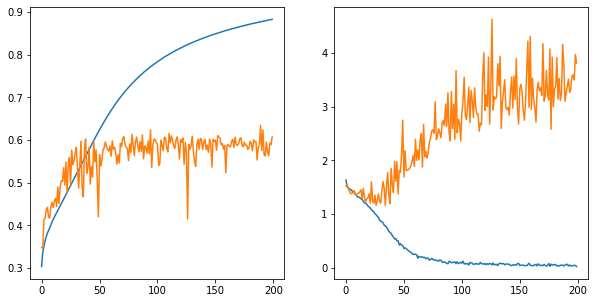

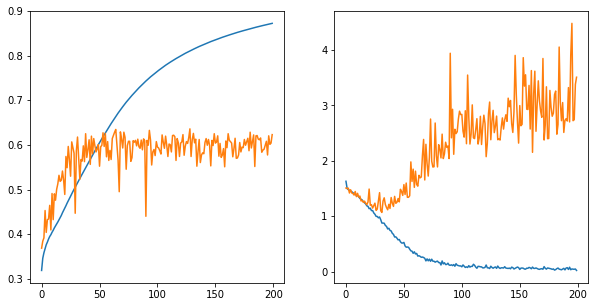

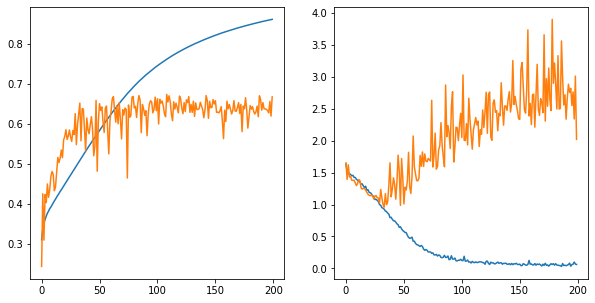

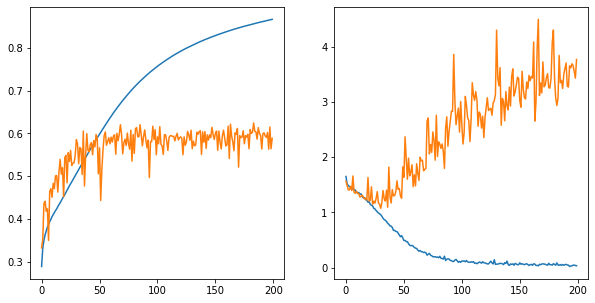

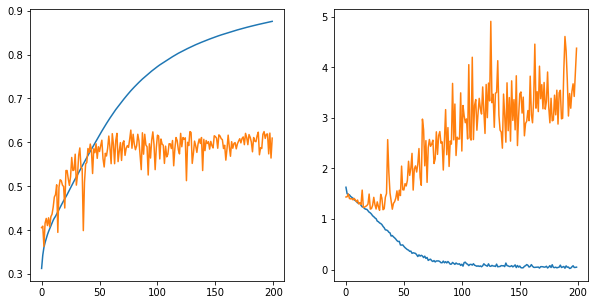

In [38]:
# draw charts
for log in log_list:
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = log
    x = np.arange(len(train_acc_list))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].plot(x, np.array(train_acc_list), x, np.array(val_acc_list))
    axs[1].plot(x, np.array(train_loss_list), x, np.array(val_loss_list))

In [82]:
val_loss_list

[1.79506202058288,
 1.7953441197418114,
 1.795343925174296,
 1.7953590356638949,
 1.7953635503380823]

In [38]:
len(female_idx_list)

43

'1.5.0'